In [5]:
#Instalar dependencias necesarias para el procesamiento de Audio
!sudo apt -y install libportaudio2
!pip install tflite-model-maker

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
#Instalar dependencias necesarias para el desarrollo del modelo
import os
import glob
import random
import shutil

import librosa
import soundfile as sf
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
from tflite_model_maker.config import ExportFormat

In [7]:
#Definir variable para usar dataset personalizado
use_custom_dataset = True

In [8]:
#Obtener datasets de ruido de fondo para lograr una mejor distincion de las palabras
tf.keras.utils.get_file('speech_commands_v0.01.tar.gz',
                        'http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz',
                        cache_dir='./',
                        cache_subdir='dataset-speech',
                        extract=True)
tf.keras.utils.get_file('background_audio.zip',
                        'https://storage.googleapis.com/download.tensorflow.org/models/tflite/sound_classification/background_audio.zip',
                        cache_dir='./',
                        cache_subdir='dataset-background',
                        extract=True)


1081344/1072437 [==============================] - 0s 0us/step


'./dataset-background/background_audio.zip'

In [9]:
#Crear una lista de todos los archivos de ruido de fondo
files = glob.glob(os.path.join('./dataset-speech/_background_noise_', '*.wav'))
files = files + glob.glob(os.path.join('./dataset-background', '*.wav'))

background_dir = './background'
os.makedirs(background_dir, exist_ok=True)

# Ciclo para iterar sobre todos los archivos de ruido de fondo y hacer split en muestras de 1 segundo
for file in files:
  filename = os.path.basename(os.path.normpath(file))
  print('Splitting', filename)
  name = os.path.splitext(filename)[0]
  rate = librosa.get_samplerate(file)
  length = round(librosa.get_duration(filename=file))
  for i in range(length - 1):
    start = i * rate
    stop = (i * rate) + rate
    data, _ = sf.read(file, start=start, stop=stop)
    sf.write(os.path.join(background_dir, name + str(i) + '.wav'), data, rate)

Splitting doing_the_dishes.wav
Splitting white_noise.wav
Splitting pink_noise.wav
Splitting dude_miaowing.wav
Splitting exercise_bike.wav
Splitting running_tap.wav
Splitting throat_clearing.wav
Splitting silence.wav


In [10]:
# Hacer uso de dataset personalizado
if use_custom_dataset:
  !unzip Data.zip # Descomprimir ZIP
  dataset_dir = './Data' # Ruta de la carpeta obtenida

Archive:  Data.zip
   creating: Data/
  inflating: __MACOSX/._Data         
  inflating: Data/.DS_Store          
  inflating: __MACOSX/Data/._.DS_Store  
   creating: Data/Tiger/
   creating: Data/Eagle/
   creating: Data/Ostrich/
   creating: Data/Lion/
   creating: Data/Elephant/
  inflating: Data/Tiger/tiger.34a65a7t.ingestion-7c57dddb4f-t8j2s.s6.wav  
  inflating: __MACOSX/Data/Tiger/._tiger.34a65a7t.ingestion-7c57dddb4f-t8j2s.s6.wav  
  inflating: Data/Tiger/tiger.34a65a7t.ingestion-7c57dddb4f-t8j2s.s7.wav  
  inflating: __MACOSX/Data/Tiger/._tiger.34a65a7t.ingestion-7c57dddb4f-t8j2s.s7.wav  
  inflating: Data/Tiger/tiger.34a65a7t.ingestion-7c57dddb4f-t8j2s.s5.wav  
  inflating: __MACOSX/Data/Tiger/._tiger.34a65a7t.ingestion-7c57dddb4f-t8j2s.s5.wav  
  inflating: Data/Tiger/tiger.34a65a7t.ingestion-7c57dddb4f-t8j2s.s4.wav  
  inflating: __MACOSX/Data/Tiger/._tiger.34a65a7t.ingestion-7c57dddb4f-t8j2s.s4.wav  
  inflating: Data/Tiger/tiger.34a65a7t.ingestion-7c57dddb4f-t8j2s.s1.wav

In [11]:
# Definición de metodo para incluir los archivos de ruido de fondo en el dataset
def move_background_dataset(dataset_dir):
  dest_dir = os.path.join(dataset_dir, 'background')
  if os.path.exists(dest_dir):
    files = glob.glob(os.path.join(background_dir, '*.wav'))
    for file in files:
      shutil.move(file, dest_dir)
  else:
    shutil.move(background_dir, dest_dir)

In [12]:
if use_custom_dataset:
  # Usar metodo
  move_background_dataset(dataset_dir)

  # Separar archivos de testeo
  test_dir = './dataset-test'
  test_data_ratio = 0.2
  dirs = glob.glob(os.path.join(dataset_dir, '*/'))
  for dir in dirs:
    files = glob.glob(os.path.join(dir, '*.wav'))
    test_count = round(len(files) * test_data_ratio)
    random.seed(42)
    random.shuffle(files)
    # Mover los archivos de testeo a una nueva carpeta
    for file in files[:test_count]:
      class_dir = os.path.basename(os.path.normpath(dir))
      os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)
      os.rename(file, os.path.join(test_dir, class_dir, os.path.basename(file)))
    print('Moved', test_count, 'images from', class_dir)

Moved 6 images from Eagle
Moved 5 images from Elephant
Moved 5 images from Ostrich
Moved 6 images from Tiger
Moved 85 images from background
Moved 6 images from Lion


In [13]:
# Metodo para obtener audio aleatorio del dataset
def get_random_audio_file(samples_dir):
  files = os.path.abspath(os.path.join(samples_dir, '*/*.wav'))
  files_list = glob.glob(files)
  random_audio_path = random.choice(files_list)
  return random_audio_path

#Metodo para mostar el archivo de audio seleccionado
def show_sample(audio_path):
  audio_data, sample_rate = sf.read(audio_path)
  class_name = os.path.basename(os.path.dirname(audio_path))
  print(f'Class: {class_name}')
  print(f'File: {audio_path}')
  print(f'Sample rate: {sample_rate}')
  print(f'Sample length: {len(audio_data)}')

  plt.title(class_name)
  plt.plot(audio_data)
  display(Audio(audio_data, rate=sample_rate))

Class: background
File: /content/dataset-test/background/doing_the_dishes54.wav
Sample rate: 16000
Sample length: 16000


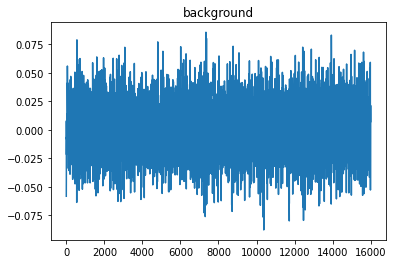

In [14]:
# Hacer uso de los metodos anteriores
random_audio = get_random_audio_file(test_dir)
show_sample(random_audio)

In [15]:
# Se instancia el modelo BRrowserFtfSpec para reentrenarlo con el dataser ajustado
spec = audio_classifier.BrowserFftSpec()

INFO:tensorflow:Checkpoints are stored in /tmp/tmpzwg2n5os
32768/18467 [=====================================================] - 0s 0us/step
16384/203 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [16]:
# Split en del dataset
if use_custom_dataset:
  train_data_ratio = 0.8
  train_data = audio_classifier.DataLoader.from_folder(
      spec, dataset_dir, cache=True)
  train_data, validation_data = train_data.split(train_data_ratio)
  test_data = audio_classifier.DataLoader.from_folder(
      spec, test_dir, cache=True)


In [17]:
# Definición de tamaño de lote, epocas y entrenamiento del modelo
batch_size = 4
epochs = 45
model = audio_classifier.create(train_data, spec, validation_data, batch_size, epochs)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 42, 225, 8)        136       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 112, 8)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 109, 32)       2080      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 51, 32)         8224      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 25, 32)       

In [18]:
# Evaluación del modelo entrenado
model.evaluate(test_data)

4/4 [==============================] - 5s 1s/step - loss: 0.0153 - acc: 0.9912


[0.015295338816940784, 0.991150438785553]

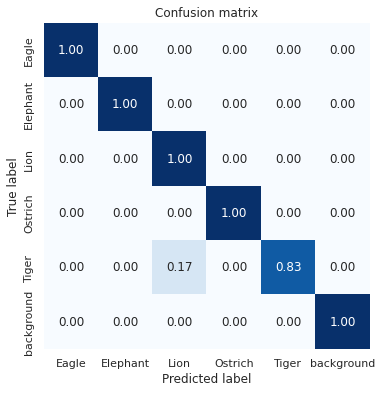

In [19]:
# Metodo para mostrar la matriz de confusión
def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  sns.set(rc = {'figure.figsize':(6,6)})
  sns.heatmap(
      confusion_normalized, xticklabels=test_labels, yticklabels=test_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True, cbar=False)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)

In [20]:
# Guardar modelo TFLite
TFLITE_FILENAME = 'browserfft-speech.tflite'
SAVE_PATH = './models'

In [21]:
# Exportando Modelo
print(f'Exporing the model to {SAVE_PATH}')
model.export(SAVE_PATH, tflite_filename=TFLITE_FILENAME)
model.export(SAVE_PATH, export_format=[mm.ExportFormat.SAVED_MODEL, mm.ExportFormat.LABEL])

Exporing the model to ./models
INFO:tensorflow:Assets written to: /tmp/tmphx9kql1p/assets
INFO:tensorflow:TensorFlow Lite model exported successfully: ./models/browserfft-speech.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./models/browserfft-speech.tflite


INFO:tensorflow:Assets written to: ./models/saved_model/assets


INFO:tensorflow:Assets written to: ./models/saved_model/assets


INFO:tensorflow:Saving labels in ./models/labels.txt


INFO:tensorflow:Saving labels in ./models/labels.txt


In [22]:
! pip install -q tflite_support

In [23]:
from tflite_support import metadata
import json

def get_labels(model):
  """Returns a list of labels, extracted from the model metadata."""
  displayer = metadata.MetadataDisplayer.with_model_file(model)
  labels_file = displayer.get_packed_associated_file_list()[0]
  labels = displayer.get_associated_file_buffer(labels_file).decode()
  return [line for line in labels.split('\n')]

def get_input_sample_rate(model):
  """Returns the model's expected sample rate, from the model metadata."""
  displayer = metadata.MetadataDisplayer.with_model_file(model)
  metadata_json = json.loads(displayer.get_metadata_json())
  input_tensor_metadata = metadata_json['subgraph_metadata'][0][
          'input_tensor_metadata'][0]
  input_content_props = input_tensor_metadata['content']['content_properties']
  return input_content_props['sample_rate']

In [25]:
# Inferencia del modelo TFLite
tflite_file = os.path.join(SAVE_PATH, TFLITE_FILENAME)
labels = get_labels(tflite_file)
random_audio = get_random_audio_file(test_dir)

# Comprobación de que el audio satisface el modelo
interpreter = tf.lite.Interpreter(tflite_file)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_size = input_details[0]['shape'][1]
sample_rate = get_input_sample_rate(tflite_file)
audio_data, _ = librosa.load(random_audio, sr=sample_rate)
if len(audio_data) < input_size:
  audio_data.resize(input_size)
audio_data = np.expand_dims(audio_data[:input_size], axis=0)

# Ejecutar inferencia
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], audio_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Desplegar la predicción y precisión
top_index = np.argmax(output_data[0])
label = labels[top_index]
score = output_data[0][top_index]
print('---prediction---')
print(f'Class: {label}\nScore: {score}')
print('----truth----')

---prediction---
Class: background
Score: 1.0
----truth----


In [26]:
# Descargar modelo
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(tflite_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>